In [1]:
import os
import random
import time

import pandas as pd
import numpy as np

import sklearn
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(rc={"axes.unicode_minus":False},
        style='darkgrid')
  
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)

## Download & Check Data

### train data

In [2]:
data_dir = '../data/train/'
data_path = os.path.join(data_dir, 'train_ratings.csv')
train_df = pd.read_csv(data_path)

In [3]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB


,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [4]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("# of unique train users: ", num_train_users)
print ("# of unique train items: ", num_train_items)

# of unique train users:  31360
# of unique train items:  6807


In [5]:
# 약 98% 채워져 있는 데이터로, 매우 dense함.
sparsity = 1 - len(train_df) / (num_train_users * num_train_items)
print(f"Data sparsity ratio: {sparsity:.2F}")

Data sparsity ratio: 0.98


### side info data

In [6]:
year_data_path = os.path.join(data_dir, 'years.tsv')
writer_data_path = os.path.join(data_dir, 'writers.tsv')
title_data_path = os.path.join(data_dir, 'titles.tsv')
genre_data_path = os.path.join(data_dir, 'genres.tsv')
director_data_path = os.path.join(data_dir, 'directors.tsv')

In [7]:
year_data = pd.read_csv(year_data_path, sep='\t')
writer_data = pd.read_csv(writer_data_path, sep='\t')
title_data = pd.read_csv(title_data_path, sep='\t')
genre_data = pd.read_csv(genre_data_path, sep='\t')
director_data = pd.read_csv(director_data_path, sep='\t')

#### year_data

In [8]:
year_data.info()
year_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    6799 non-null   int64
 1   year    6799 non-null   int64
dtypes: int64(2)
memory usage: 106.4 KB


,item,year
0,1348,1922
1,44587,1922
2,4768,1922


In [9]:
print ("year data shape: ", year_data.shape)
print("# of unique items in year data: ", year_data.item.nunique())
print("# of unique years: ", year_data.year.nunique())
print ("\nStatistics of year data: ")
year_data.year.describe()

year data shape:  (6799, 2)
# of unique items in year data:  6799
# of unique years:  93

Statistics of year data: 


count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64

#### writer_data

In [10]:
writer_data.info()
writer_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    11306 non-null  int64 
 1   writer  11306 non-null  object
dtypes: int64(1), object(1)
memory usage: 176.8+ KB


,item,writer
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005


In [11]:
print ("writer data shape: ", writer_data.shape)
print("# of unique items in writer data: ", writer_data.item.nunique())
print("# of unique writers: ", writer_data.writer.nunique())

writer data shape:  (11306, 2)
# of unique items in writer data:  5648
# of unique writers:  2989


#### title_data

In [12]:
title_data.info()
title_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    6807 non-null   int64 
 1   title   6807 non-null   object
dtypes: int64(1), object(1)
memory usage: 106.5+ KB


,item,title
0,318,"Shawshank Redemption, The (1994)"
1,2571,"Matrix, The (1999)"
2,2959,Fight Club (1999)


In [13]:
print ("title data shape: ", title_data.shape)
print("# of unique items in title data: ", title_data.item.nunique())
print("# of unique titles: ", title_data.title.nunique())

title data shape:  (6807, 2)
# of unique items in title data:  6807
# of unique titles:  6806


#### genre_data

In [14]:
genre_data.info()
genre_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15933 entries, 0 to 15932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    15933 non-null  int64 
 1   genre   15933 non-null  object
dtypes: int64(1), object(1)
memory usage: 249.1+ KB


,item,genre
0,318,Crime
1,318,Drama
2,2571,Action


In [15]:
print ("genre data shape: ", genre_data.shape)
print("# of unique items in genre data: ", genre_data.item.nunique())
print("# of unique genres: ", genre_data.genre.nunique())

genre data shape:  (15933, 2)
# of unique items in genre data:  6807
# of unique genres:  18


#### director_data

In [16]:
director_data.info()
director_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item      5905 non-null   int64 
 1   director  5905 non-null   object
dtypes: int64(1), object(1)
memory usage: 92.4+ KB


,item,director
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005


In [17]:
print ("director data shape: ", director_data.shape)
print("# of unique items in director data: ", director_data.item.nunique())
print("# of unique directors: ", director_data.director.nunique())

director data shape:  (5905, 2)
# of unique items in director data:  5503
# of unique directors:  1340


### train data + side info data

#### 빈도수가 높은 순 top10을 `active_users_ids`, `popular_movie_ids` 저장

In [18]:
active_user_ids = train_df.value_counts('user').index[:10]
popular_movie_ids = train_df.value_counts('item').index[:10]

print ("active user ids: ", active_user_ids)
print ("\npopular movie ids: ", popular_movie_ids)

active user ids:  Index([8405, 54465, 24219, 32514, 91349, 131904, 34576, 99754, 31122, 118754], dtype='int64', name='user')

popular movie ids:  Index([2571, 2959, 296, 318, 356, 4993, 7153, 5952, 593, 2858], dtype='int64', name='item')


#### side info 별 user-item 빈도수 top10 데이터 샘플을 저장

year

In [19]:
year_df = pd.merge(train_df, year_data, on=['item'])
year_id = year_df.value_counts('year').index[:10]

tmp = []
for year in year_id:
  tmp.append(year_df.loc[year_df.year == year])

year_top = pd.concat(tmp)

print ("All unique years: \n", np.sort(year_df.year.unique())) 
print ("\n# of all unique years: ", year_df.year.nunique())
print ("\ntop 10 years: \n", year_id)
print ("\nsample of top 10 user-year data: \n", year_top.sample(5))
print ("\nshape of the data: ", year_top.shape)

All unique years: 
 [1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935
 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014]

# of all unique years:  93

top 10 years: 
 Index([2004, 1999, 2001, 2002, 2006, 2003, 2000, 2005, 1995, 2007], dtype='int64', name='year')

sample of top 10 user-year data: 
           user   item        time  year
2413125  47031  34437  1147045927  2005
4240235  93323  45447  1169263900  2006
3248757  34576   5294  1163520644  2001
115334   71357   2858  1406553928  1999
1711491  51335   4967  1118066396  2001

shape of the data:  (2173226, 4)


In [20]:
year_top.info()
year_top.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 2173226 entries, 28067 to 5150370
Data columns (total 4 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
 3   year    int64
dtypes: int64(4)
memory usage: 82.9 MB


,user,item,time,year
28067,11,7444,1230783123,2004
28068,61,7444,1197066399,2004
28069,279,7444,1328818899,2004


writer

In [21]:
writer_df = pd.merge(train_df, writer_data, on=['item'])
writer_id = writer_df.value_counts('writer').index[:10]

tmp = []
for writer in writer_id:
  tmp.append(writer_df.loc[writer_df.writer == writer])

writer_top = pd.concat(tmp)

print ("# of all unique writer ids: ", writer_df.writer.nunique())
print ("\ntop 10 writer ids: \n", writer_id)
print ("\nsample of top 10 user-writer data: \n", writer_top.sample(5))
print ("\nshape of the data: ", writer_top.shape)

# of all unique writer ids:  2989

top 10 writer ids: 
 Index(['nm0000184', 'nm0000233', 'nm0634240', 'nm0001392', 'nm0909638',
       'nm0004056', 'nm0744429', 'nm0101991', 'nm0254645', 'nm0000175'],
      dtype='object', name='writer')

sample of top 10 user-writer data: 
           user    item        time     writer
1819328  87075    2355  1357675987  nm0004056
5554933  78253  106489  1387639838  nm0001392
4276403  53747    4886  1238778710  nm0004056
542165   22610     260  1346562966  nm0000184
2081056  30069     296  1144177342  nm0000233

shape of the data:  (651286, 4)


In [22]:
writer_top.info()
writer_top.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 651286 entries, 539754 to 11275678
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   user    651286 non-null  int64 
 1   item    651286 non-null  int64 
 2   time    651286 non-null  int64 
 3   writer  651286 non-null  object
dtypes: int64(3), object(1)
memory usage: 24.8+ MB


,user,item,time,writer
539754,11,260,1230787560,nm0000184
539755,14,260,1225311540,nm0000184
539756,31,260,1424733433,nm0000184


title

In [23]:
title_df = pd.merge(train_df, title_data, on=['item'])
title_id = title_df.value_counts('title').index[:10]

tmp = []
for title in title_id:
    tmp.append(title_df.loc[title_df.title == title])

title_top = pd.concat(tmp)

print ("# of all unique movie titles: ", title_df['title'].nunique())
print ("\ntop 10 movie titles: \n", title_id)
print ("\nsample of top 10 user-title data: \n", title_top.sample(5))
print ("\nshape of the data: ", title_top.shape)

# of all unique movie titles:  6806

top 10 movie titles: 
 Index(['Matrix, The (1999)', 'Fight Club (1999)', 'Pulp Fiction (1994)',
       'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)',
       'Lord of the Rings: The Fellowship of the Ring, The (2001)',
       'Lord of the Rings: The Return of the King, The (2003)',
       'Lord of the Rings: The Two Towers, The (2002)',
       'Silence of the Lambs, The (1991)', 'American Beauty (1999)'],
      dtype='object', name='title')

sample of top 10 user-title data: 
            user  item        time  \
833328    10217   296  1257676409   
1085642  130096  5952  1423211852   
1083112  108754  5952  1331765867   
803109    16088  2959  1286088974   
857004    54612   356  1303472932   

                                                 title  
833328                             Pulp Fiction (1994)  
1085642  Lord of the Rings: The Two Towers, The (2002)  
1083112  Lord of the Rings: The Two Towers, The (2002)  
803109             

In [24]:
title_top.info()
title_top.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 173185 entries, 222427 to 122780
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   user    173185 non-null  int64 
 1   item    173185 non-null  int64 
 2   time    173185 non-null  int64 
 3   title   173185 non-null  object
dtypes: int64(3), object(1)
memory usage: 6.6+ MB


,user,item,time,title
222427,11,2571,1230787515,"Matrix, The (1999)"
222428,25,2571,1277963409,"Matrix, The (1999)"
222429,31,2571,1424736532,"Matrix, The (1999)"


director

In [25]:
director_df = pd.merge(train_df, director_data, on=['item'])
director_id = director_df.value_counts('director').index[:10]

tmp = []
for director in director_id:
  tmp.append(director_df.loc[director_df.director == director])

director_top = pd.concat(tmp)

print ("# of all unique director ids: ", director_df.director.nunique())
print ("\ntop 10 director ids: \n", director_id)
print ("\nsample of top 10 user-director data: \n", director_top.sample(5))
print ("\nshape of the data: ", director_top.shape)

# of all unique director ids:  1340

top 10 director ids: 
 Index(['nm0000229', 'nm0000233', 'nm0634240', 'nm0000709', 'nm0001392',
       'nm0000217', 'nm0001054', 'nm0000116', 'nm0000399', 'nm0000631'],
      dtype='object', name='director')

sample of top 10 user-director data: 
            user   item        time   director
1367094   94571  58559  1415325426  nm0634240
1225950   53545   5952  1326683909  nm0001392
105340   113629   1320  1143253766  nm0000399
1550050  118478   7153  1159917697  nm0001392
200807   121543   2012  1168333792  nm0000709

shape of the data:  (672019, 4)


In [26]:
director_top.info()
director_top.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 672019 entries, 341943 to 5359011
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      672019 non-null  int64 
 1   item      672019 non-null  int64 
 2   time      672019 non-null  int64 
 3   director  672019 non-null  object
dtypes: int64(3), object(1)
memory usage: 25.6+ MB


,user,item,time,director
341943,11,1544,1230787983,nm0000229
341944,58,1544,1144059266,nm0000229
341945,421,1544,1192346253,nm0000229


genre  
앞에서 봤듯이, unique한 genre 수는 18개뿐이므로, 빈도수 높은 genre 따로 저장하지 않고, 바로 merge함

In [27]:
genre_top = pd.merge(train_df, genre_data, on=['item'])

print ("All unique genres: \n", np.sort(genre_top.genre.unique())) 
print ("\n# of all unique genres: ", genre_top.genre.nunique())
print ("\nsample of user-genre data: \n", genre_top.sample(5))
print ("\nshape of the data: ", genre_top.shape)

All unique genres: 
 ['Action' 'Adventure' 'Animation' 'Children' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']

# of all unique genres:  18

sample of user-genre data: 
            user   item        time      genre
8853475   15950   2947  1275161705  Adventure
9783413  126447  97304  1362603676   Thriller
1244018  131138  57640  1216357456     Sci-Fi
1631583   45619    546  1148782839     Comedy
2303306   72657  54001  1226270821    Fantasy

shape of the data:  (14126324, 4)


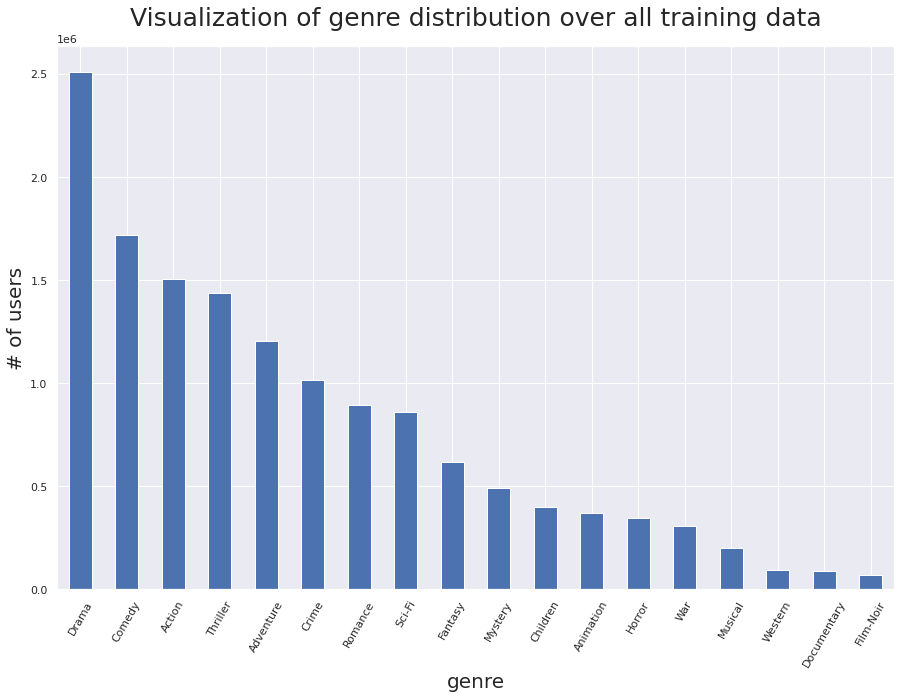

In [28]:
genre_top.genre.value_counts().plot(kind='bar', figsize=(15, 10), rot=60,)
plt.xlabel('genre', size=20)
plt.ylabel('# of users', size=20)
plt.title('Visualization of genre distribution over all training data', size=25, pad=20);

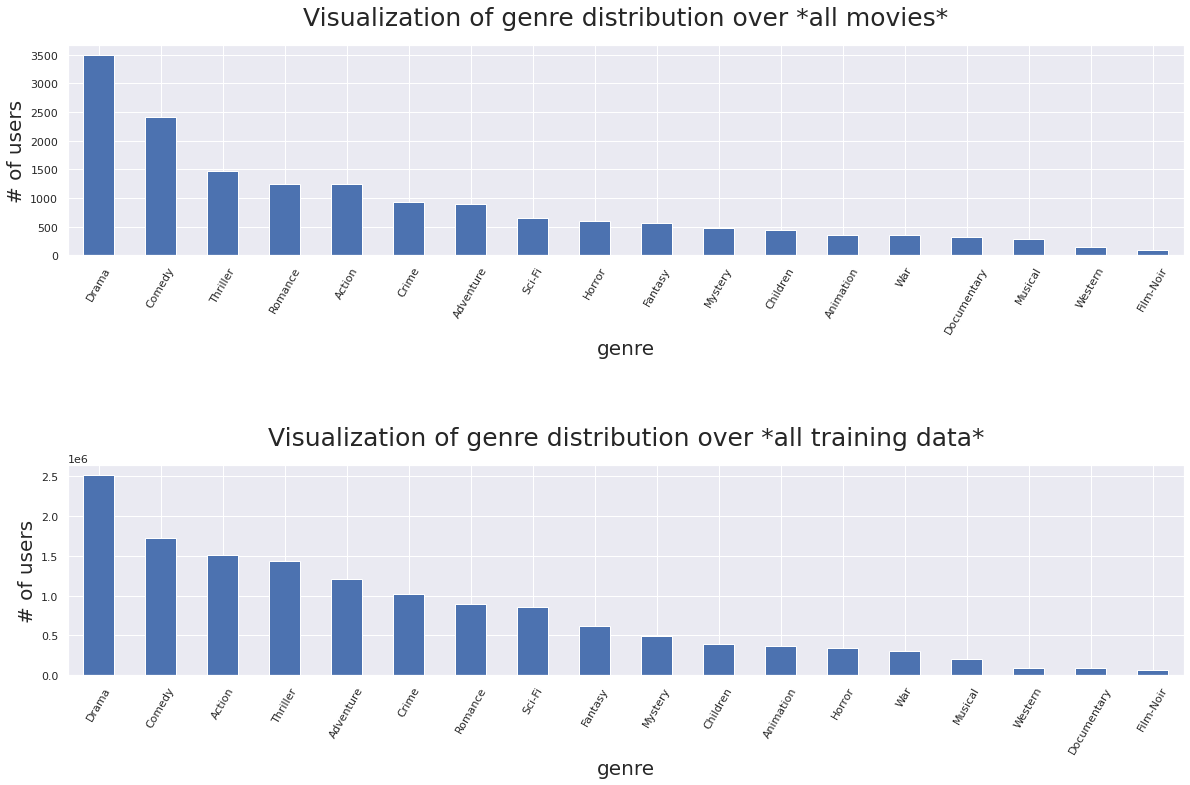

In [29]:
plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
genre_data.genre.value_counts().plot(kind='bar', rot=60)
plt.xlabel('genre', size=20)
plt.ylabel('# of users', size=20)
plt.title('Visualization of genre distribution over *all movies*', size=25, pad=20)

plt.subplot(2,1,2)
genre_top.genre.value_counts().plot(kind='bar', rot=60)
plt.xlabel('genre', size=20)
plt.ylabel('# of users', size=20)
plt.title('Visualization of genre distribution over *all training data*', size=25, pad=20)

plt.subplots_adjust(hspace=1, top=1.0)

- `genre_data` (all movies)
- `genre_top` (all training data)

user가 제일 선호하는 장르를 순위별로

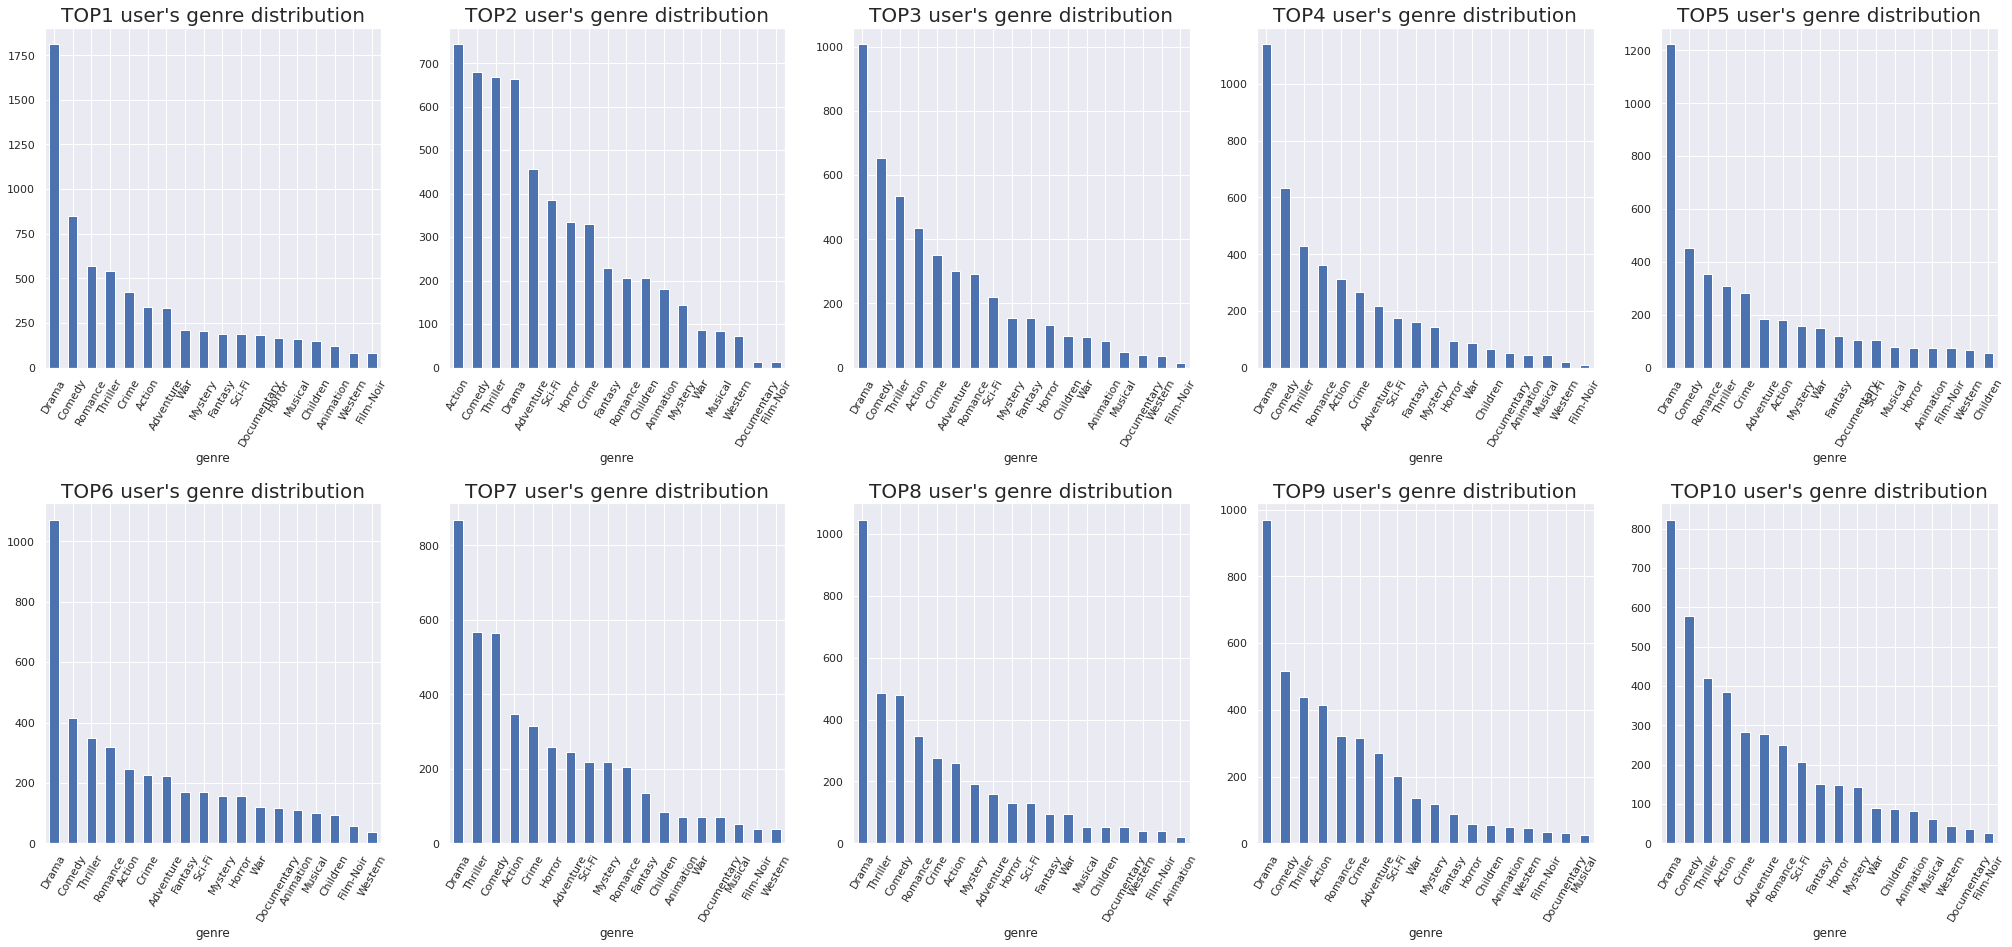

In [30]:
# https://stackoverflow.com/questions/64189469/how-to-resolve-attributeerror-numpy-ndarray-object-has-no-attribute-get-figu
fig, axes = plt.subplots(nrows=2, ncols=5)
plt.subplots_adjust(hspace=0.4)

for (idx, uid), ax in zip(enumerate(active_user_ids), [x for ravel in axes for x in ravel]):
  genre_user = genre_top.loc[genre_top.user == uid]
  genre_user.genre.value_counts().plot(kind='bar', figsize=(35, 15), rot=60, ax=ax,)
  ax.set_title(f"TOP{idx+1} user's genre distribution", fontdict={'fontsize': 20})

- 제일 active한 user의 시청영화 장르 분포와 전체 데이터의 장르 분포와 큰 차이 X
- 순위 변동은 있지만, 전반적으로 "Drama", "Comedy", "Thriller", "Action", "Crime", "Romance", "Adventure"가 많은 편.